# Python機械学習 勉強会 第十四回「アルゴリズムチェーンとパイプライン、まとめ」

参考文献：  
Pythonではじめる機械学習　6章, 8章  
https://github.com/amueller/introduction_to_ml_with_python/blob/master/06-algorithm-chains-and-pipelines.ipynb  
https://github.com/amueller/introduction_to_ml_with_python/blob/master/08-conclusion.ipynb

scikit-learnドキュメント：  
https://scikit-learn.org/stable/documentation.html

In [14]:
%matplotlib inline
from preamble import *
from sklearn.model_selection import train_test_split

In [15]:
# ワーニングを無視
import warnings
warnings.filterwarnings('ignore')

# pandasの行や列を省略しないようにする
pd.options.display.max_columns = None
pd.options.display.max_rows = None

<br>

---

## はじめに

最終回は以下の内容を取り組む

* 前処理を行う際のパラメータ選択
* パイプラインの構築
* パイプラインを用いたグリッドサーチ
* 汎用パイプラインインターフェイス
* 前処理ステップとモデルパラメータに対するグリッドサーチ
* グリッドサーチによるモデルの選択
* 総まとめ

<br>

---

## 6 アルゴリズムチェーンとパイプライン

多くの機械学習アプリケーションでは、1つのアルゴリズムを実行するだけでなく、  
さまざまな処理と複数の機械学習アルゴリズムを連鎖的に実行する必要がある。

ここでは、***Pipeline***クラスと***GridSearchCV***を用いて、全ての処理ステップを一度に行う方法を学ぶ。

例として、cancerデータセットを用いて、モデルチェーンの効果を確認する。

In [16]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# データをロードして分割
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

# 訓練データの最小値と最大値を計算
scaler = MinMaxScaler().fit(X_train)

In [17]:
# 訓練データをスケール変換
X_train_scaled = scaler.transform(X_train)

svm = SVC()

# SVMをスケール変換したデータで訓練
svm.fit(X_train_scaled, y_train)

# テストデータをスケール変換し、それを用いて評価
X_test_scaled = scaler.transform(X_test)
print("Test score: {:.2f}".format(svm.score(X_test_scaled, y_test)))

Test score: 0.95


<br>

---

### 6.1 前処理を行う際のパラメータ選択

ここで、***GridSearchCV***を用いて、より良いパラメータを求めることを考えてみる。  
単純に実装すると次のようになる。

In [18]:
from sklearn.model_selection import GridSearchCV

# 説明のためのコードであり、実際はこんな風に作ってはいけない
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Test set accuracy: {:.2f}".format(grid.score(X_test_scaled, y_test)))

Best cross-validation accuracy: 0.98
Best parameters:  {'C': 1, 'gamma': 1}
Test set accuracy: 0.97


<br>

ここでは、SVCのパラメータに対してスケール変換されたデータを用いてグリッドサーチを行っている。  
しかし、データをスケール変換する際に、**訓練セットのすべてのデータ**を用いているという問題がある。

交差検証では一部を訓練データ、残りをテストデータに分割するのだが、  
この際のテストデータとなった部分に含まれている情報を用いてスケール変換してしまっている。

つまり、モデルに対してまったく新しいデータとは本質的に異なってしまう。

* ただし、実際にはスケール変換位では大きな影響はない。  
    ただし、特徴量抽出や特徴量選択ではかなり影響が出てしまうので注意が必要。

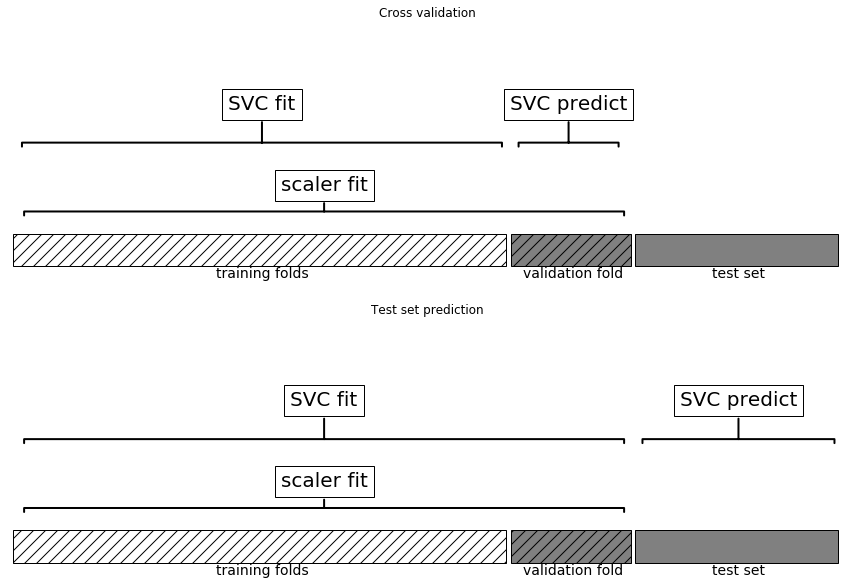

In [19]:
mglearn.plots.plot_improper_processing()

この問題を回避するためには、**前処理をする前に**交差検証のためのデータ分割を行う必要がある。

これを実現するために、scikit-learnでは***cross_val_score***関数と***GridSearchCV***関数に、  
***Pipeline***クラスを使うことができる。

***Pipeline***クラスは、前処理ステップ(スケール変換など)とクラス分類器などの教師あり学習モデルを組み合わせるためによく使われる。

<br>

---

### 6.2 パイプラインの構築

***Pipeline***クラスを用いて、***MinMaxScaler***によるスケール変換を行ってからSVMを訓練するワークフローを確認する。
* ここではグリッドサーチは行わない

<br>

まず、各ステップをリストとして指定し***Pipeline***オブジェクトを作る。  
個々のステップは、名前とEstimatorのインスタンスのタプルで表現する。

In [20]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])

ここでは2つのステップを作っている。

1つ目は、"scaler"という名前で***MinMaxScaler***のインスタンス、  
2つ目は、"svm"という名前で***SVC***のインスタンス。

<br>

作成した***Pipeline***オブジェクトに対して、他のEstimator同様に***fit***メソッドを呼び出す。

In [21]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

ここでは、まず第1ステップ(scaler)のfitを呼び出して、訓練データを***scaler***を用いて変換、  
次にSVMに対して変換されたデータを用いて***fit***する。

<br>

テストデータを用いて評価するには、pipe.scoreを用いればよい。

In [22]:
print("Test score: {:.2f}".format(pipe.score(X_test, y_test)))

Test score: 0.95


パイプラインの***score***メソッドを呼ぶと、まずテストデータを***scaler***で変換し、  
SVMの***score***メソッドを変換されたデータで呼び出す。

パイプラインを用いると、「前処理＋クラス分類」プロセスに必要なコード量を減らすことができる。

<br>

---

### 6.3 パイプラインを用いたグリッドサーチ

パイプラインをグリッドサーチで用いる場合は、パラメータグリッドの定義を少し変更する。

具体的には、個々のパラメータに対して、パイプラインのどのステップに属するか指定する必要がある。

<br>

ここでは、パラメータ***C***、***gamma***ともに2つ目のステップである***SVC***のパラメータである。

パイプラインに対してパラメータグリッドを定義するには、ステップ名に"__(連続したアンダースコア)"を続け、  
個々のパラメータ名を組み合わせればよい。

In [23]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [24]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.98
Test set score: 0.97
Best parameters: {'svm__C': 1, 'svm__gamma': 1}


この方法では、「6.1」章で行ったグリッドサーチと異なり、交差検証の個々の分割に対して、  
訓練用のパートのみを対象として***MinMaxScaler***を***fit***し直すので、リークは発生しない。

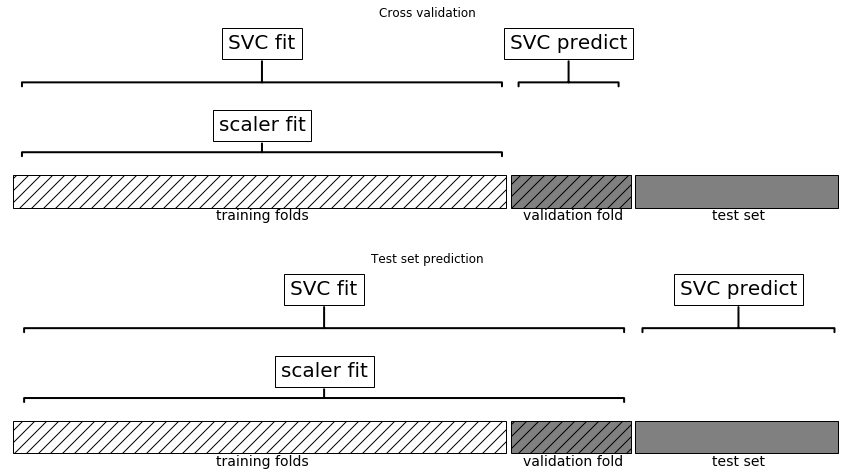

In [25]:
mglearn.plots.plot_proper_processing()

<br>

---

### 6.4 汎用パイプラインインターフェイス

Pipelineクラスが適用できるのは、前処理とクラス分類に限られているわけではない。  
例えば、特徴量抽出、特徴量選択、スケール変換、クラス分類など4ステップのパイプラインを作ることもできる。
* もちろん最後のステップを、回帰やクラスタリングなどにすることもできる。

<br>

パイプラインに並べるEstimatorに関する制約は、最後以外のステップには***transform***メソッドが定義されている必要があることだけ。
* 次のステップで使うデータの新しい表現を生成するため

<br>

内部的には、Pipeline.fitが呼び出されると、各ステップに対して前段のステップのtransformメソッドの出力を入力として、  
fitを呼び出してからtransformを呼び出す。  
パイプラインの最後のステップではfitだけが呼ばれる。

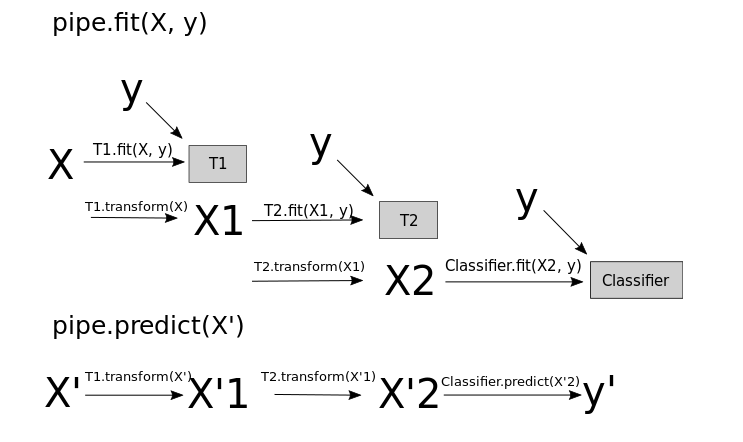

In [26]:
from IPython.display import Image, display_png
display_png(Image('./image/pipeline.png'))

<br>

#### 6.4.1 make_pipelineによる簡便なパイプライン生成

パイプラインを簡便にする関数***make_pipeline***について説明する。

この関数はクラス名に基づいて個々のステップに自動的に名前を付けてくれる。
* 作られたステップ名は***steps***属性に格納される

In [27]:
from sklearn.pipeline import make_pipeline
# 標準の文法
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])

# 短縮文法
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

In [28]:
print("Pipeline steps:\n{}".format(pipe_short.steps))

Pipeline steps:
[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]


ここで自動的に付けられた名前は、minmaxscaler, svcとなっている。

<br>

#### 6.4.2 ステップ属性へのアクセス

パイプラインに含まれる各ステップの属性を見たい場合がある。  
そのような場合は***named_steps***属性を確認する。

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print("Pipeline steps:\n{}".format(pipe.steps))

Pipeline steps:
[('standardscaler-1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('standardscaler-2', StandardScaler(copy=True, with_mean=True, with_std=True))]


<br>

#### 6.4.3 GridSearchCV内のパイプラインの属性へのアクセス

パイプラインを使う目的の1つはグリッドサーチである。  

ここではcancerデータセットに対してLogisticRegressionクラス分類器を用いてグリッドサーチをしてみる。  
***Pipeline***を用いてLogisticRegressionにデータを渡す前に、***StandardScaler***によるスケール変換を行う。

In [30]:
from sklearn.linear_model import LogisticRegression

# パイプラインを作る
pipe = make_pipeline(StandardScaler(), LogisticRegression())

# パラメータグリッドを設定する
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

# データを訓練セットとテストセットに分割し、グリッドサーチを行う
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

ここで、GridSearchCVが見つけた最良のLogisticRegressionモデルの係数を確認してみる。

最良のモデルは、***grid.best_estimator_***に格納されている。

In [31]:
print("Best estimator:\n{}".format(grid.best_estimator_))

Best estimator:
Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])


この場合、***best_estimator_***には、standardscalerとlogisticregressionの2ステップからなるパイプラインが格納されている。

さらにlogisticregressionにアクセスするには、***named_steps***属性を用いる。

In [32]:
print("Logistic regression step:\n{}".format(
      grid.best_estimator_.named_steps["logisticregression"]))

Logistic regression step:
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


これによってLogisticRegressionインスタンスにアクセスできたので、個々の入力特徴量に対応する係数(重み)を確認できる。

In [33]:
print("Logistic regression coefficients:\n{}".format(
      grid.best_estimator_.named_steps["logisticregression"].coef_))

Logistic regression coefficients:
[[-0.389 -0.375 -0.376 -0.396 -0.115  0.017 -0.355 -0.39  -0.058  0.209
  -0.495 -0.004 -0.371 -0.383 -0.045  0.198  0.004 -0.049  0.21   0.224
  -0.547 -0.525 -0.499 -0.515 -0.393 -0.123 -0.388 -0.417 -0.325 -0.139]]


<br>

---

### 6.5 前処理ステップとモデルパラメータに対するグリッドサーチ

パイプラインを使うと、機械学習ワークフローのすべてのステップを1つの***Estimator***にカプセル化することができる。  
そのメリットの1つが、回帰やクラス分類などの教師あり学習タスクの結果を使って、前処理のパラメータの調整を行うことができることだ。

具体的な効果を、boston_housingデータセットに対して確認してみる。  
ここでは、データのスケール変換、多項式特徴量の計算、リッジ回帰の3つのステップが含まれる。

In [34]:
from sklearn.datasets import load_boston
from sklearn.linear_model import Ridge

boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,
                                                    random_state=0)

from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge())

パイプラインを用いると、Ridgeの***alpha***パラメータと同時に、PolynomialFeaturesの***dgree***パラメータをサーチできる。

In [35]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

In [36]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'polynomialfeatures__degree': [1, 2, 3], 'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

以前(5章 モデルの評価と改良)で説明した通り、交差検証の結果をヒートマップで可視化できる。

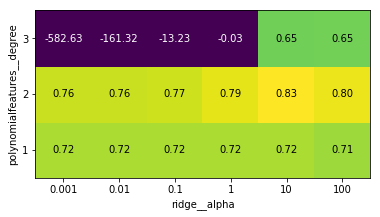

In [37]:
mglearn.tools.heatmap(grid.cv_results_['mean_test_score'].reshape(3, -1),
                      xlabel="ridge__alpha", ylabel="polynomialfeatures__degree",
                      xticklabels=param_grid['ridge__alpha'],
                      yticklabels=param_grid['polynomialfeatures__degree'], vmin=0)

また、最良のパラメータなどを確認できる。

In [38]:
print("Best parameters: {}".format(grid.best_params_))

Best parameters: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


ヒートマップの結果から2次の多項式が一番性能がよさそうな事が分かるし、それは***best_params_***からも伺える。

In [39]:
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Test-set score: 0.77


今回のように、前処理のパラメータとモデルのパラメータを同時にサーチするのは非常に強力な戦略である。

ただし、全てのパラメータの組み合わせを探索するので、計算コストには気を付けること。

<br>

---

### 6.6 グリッドサーチによるモデルの選択

他の利用法としては、パイプラインの各ステップに対しても、GridSearchCVを用いてサーチすることだ。  
例えば、***StandardScaler***と***MinMaxScaler***のどちらを用いるか、サーチの対象にすることができる。

* もちろん探索空間が大きくなるので、よく考えて行うこと

ここでは、irisデータセットに対して、RandomForestClassifierとSVCを比較する例を用いて確認する。

SVCの場合はスケール変換が必要だが、RandomForestFlassifierでは不要である。

In [40]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

In [41]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler(), None],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestClassifier(n_estimators=100)],
     'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}]

ここでは、まずStandardScalerとSVCとでパイプラインを定義している。

そのあとに、パラメータグリッドに、SVCとRandomForestClassifierの分類器とそれぞれのパラメータを設定した。

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best params:
{'classifier': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

Best cross-validation score: 0.99
Test-set score: 0.98


このグリッドサーチの結果から、StandardScalerで前処理したSVCで、***C***=10, ***gamma***=0.01が最良であったことが分かる。

<br>

---

### 6.7 アルゴリズムチェーンとパイプラインのまとめ

本章では、機械学習ワークフローの処理ステップを1つなぎにまとめる汎用ツール***パイプライン***を学んだ。

***PipeLine***クラスを用いると、コードが簡単になりミスが少なくなるなど効率化につながる。

ここまでで、scikit-learnが提供する汎用のツールとアルゴリズムを、一通り学んできた。  
今までの勉強会全てに参加し、手を動かして学んできた皆さんであれば、実業務へ十分適用することができると思われる。

<br><br><br>

---

## 7 総まとめ

ここでは、さらに学習を続けるのに役立つリソースを紹介し、データサイエンス技術を磨く方法についてアドバイスを見ていこう。

<br>

---

### 7.1 機械学習問題へのアプローチ

ここまで学んできた事を活かし、すぐにでも手元のデータで試してみたくなるかもしれない。

しかし、ただやるのではなく、大きな目標を意識しよう。

* 何らかのゴールを設定する
* 成功を測る基準を設定する
* 成功した場合にビジネスや研究の目標にどのような影響を与えるか考える

機械学習アルゴリズムは、大きなデータ解析と意思決定過程の、ごく一部でしかないことを肝に銘じよう。

<br>

#### 7.1.1 人間をループに組み込み

機械学習アルゴリズムのみでは達成できない高い精度が求められている場合、人間をループに組み込もう。

たとえアルゴリズムが10%しか自動で判断できないとしても、それだけで応答時間を短縮しコストを低減できる場合がある。

<br>

---

### 7.2 プロトタイプから運用システムへ

本勉強会で説明したツールは、解析やプロトタイプ構築を手早く行うのに適している。  
一方で、多くの会社は複雑なインフラを持っており、いつも容易にPythonを組み込みえるとは限らない。

運用システムには、使い捨ての解析スクリプトとは異なる性質が要求される。
* 信頼性
* 予測可能性
* 実行時ライブラリ
* メモリ使用量

複雑な機械学習システムを構築する場合には、以下のドキュメントをチェックするとよい。

「Machine Learning: The High Interest Credit Card of Technical Debt」  
https://research.google/pubs/pub43146/  

日本語解説1：http://auderghem.hatenablog.com/entry/2019/04/30/224821  
日本語解説2：http://zawa.hatenadiary.com/entry/2017/03/31/215333


<br>

---

### 7.3 運用システムのテスト

今までは、事前に収集したテストセットでモデルを評価する方法を説明してきた。
* これをオフライン評価と呼ぶ

しかし、その機械学習システムがユーザーに対して運用されるのであれば、  
次のステップは**オンラインテスト**もしくは***ライブテスト***である。

これらは実際にアルゴリズムを導入したシステム全体が評価される。

<br>

例えば、Webサイトなどでは***A/Bテスト***と呼ばれる手法などが取られる。  
これは、情報を伏せたユーザー調査であり、片方にはアルゴリズムA、もう片方にはアルゴリズムBを用いて、  
どちらの方が目的に対して有効か調査する手法である。

<br>

オンラインテストにはより複雑な**バンディットアルゴリズム**などもあるので、  
興味があれば詳しく調べて欲しい。

<br>

---

### 7.4 独自Estimatorの構築

scikit-learnにはさまざまなツールやアルゴリズムが実装されているが、  
実装されていないオリジナルの処理をしなければいけない場合もある。

そういった場合は、独自のEstimatorを作ればよい。  

scikit-learnと互換性を持つインターフェイスを持つEstimatorを実装すれば、  
PipelineやGridSearchCV, cross_val_scoreで利用できる。

<br>

詳細は以下のドキュメントを参照して欲しい。  
https://scikit-learn.org/stable/developers/develop.html#rolling-your-own-estimator

<br>

---

### 7.5 ここからどこに行くのか

ここでは、機械学習の技術をさらに磨きたいと考える人のために、  
より深く研究するための書籍や個別技術に関する参考リソースを紹介する。

<br>

#### 7.5.1 理論

これまでは数学や理論などは深く扱ってこなかったが、機械学習アルゴリズムの背景にある理論を知っておくことは、  
データサイエンティストとして重要だと考えられる。

ここでは、著名な本を紹介しておく。

1. 統計的学習の基礎：　データマイニング・推論・予測　@共立出版株式会社
1. パターン認識と機械学習　上下巻 @丸善出版株式会社

<br>

また、より初心者向けとしては、以下の本などから手を付けると良いと考えられる。
1. 統計学のための数学入門30講 @朝倉書店
1. 統計学入門 @東京大学出版会
1. 機械学習のエッセンス @SB Creative
1. はじめてのパターン認識 @森北出版株式会社
1. これならわかる最適化数学 @共立出版株式会社

<br>

#### 7.5.2 他の機械学習フレームワークとパッケージ

基本的にはPythonとscikit-learnのパッケージを用いれば、たいていの機械学習アプリケーションは問題ない。

ただし場合によっては他のツールを使うほうが良い場合もある。
* 例えば、統計解析に特化した言語では**R**など

それ以外にも、深層学習を試したいならば、TensorFlow、Pytorchなどなど、  
様々なフレームワークが提供されているので、必要に応じて使いたい。

<br>

---

### 7.6 結論

機械学習が幅広いアプリケーションに対して有用で、実際に実装するのも簡単だ、  
ということを理解し、体験しててもらえたと思う。

今後もこの勉強会で学んだことを活かし、データ解析を推進して欲しい。

ただし、問題の全体像を見ることは忘れずに。

<br><br><br>

---

# 8 おわりに

ここまで機械学習勉強会にご参加頂き、誠にありがとうございます。

2020年2月現在、駆動技術部という号口部署における(恐らく)初めての取り組みであり、  
準備不足によって参加者の皆さんには様々なご迷惑をおかけしたこと、申し訳ありません。

<br>

ただし、今までなかなか手を出すことが難しかったデータサイエンスという領域において、  
少しでも楽しめながら勉強会に参加できたのであれば、私としては僥倖であります。

<br>

号口部署という性質上、新しい技術に触れることは少ないかもしれません。

それを危惧し、素人ながら講師役として勉強会を企画・推進できたことは、  
私としても新鮮であり貴重な経験になりました。

改めまして、ご参加頂きありがとうございます。

<br>

今後も、各自データサイエンスを活用できる機会を見つけ、  
より効率的な・効果的な成果を生み出されることを期待したいと思います。

<br>

もちろん、機械学習をやるのが目的ではないハズなので、最終的な目標は明確にしてからですけどね！

<br>

最後に、本テキスト一式については、今後自由にご利用頂いて構いません。  
改変・改定・再配布ご自由にどうぞ。連絡も不要です。

それでは、またどこかでお会いできることを期待して(｀・ω・´)ﾉｼ